## Generate the mesh

In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)
nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)


meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
import ipyparallel as ipp
import numpy as np

def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2
    import time

    start = time.perf_counter()
    run_festim_2(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.79s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1646051, 'identifier': 'ipcontroller-1731458942-gg13-1593173'}
Stopping engine(s): 1731458943
Output for ipengine-1731458942-gg13-1731458943-1593173:
2024-11-12 19:49:03.617 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:49:03.617 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:49:03.768 [IPEngine] Registering with controller at tcp://127.0.0.1:58009
2024-11-12 19:49:03.771 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:43391', 'tcp://127.0.0.1:44141', 'tcp://127.0.0.1:57735']
2024-11-12 19:49:03.771 [IPEngine] Connecting shell to tcp://127.0.0.1:43391
2024-11-12 19:49:03.771 [IPEngine] Connecting shell to tcp://127.0.0.1:44141
2024-11-12 19:49:03.771 [IPEngine] Connecting shell to tcp://127.0.0.1:57735
2024-11-12 19:49:03.771 [I

/tmp/ipykernel_1593173/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.76s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1646225, 'identifier': 'ipcontroller-1731458986-exls-1593173'}
Stopping engine(s): 1731458987
Output for ipengine-1731458986-exls-1731458987-1593173:
2024-11-12 19:49:47.512 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:49:47.512 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:49:47.512 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:49:47.512 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:49:47.567 [IPEngine.1] Registering with controller at tcp://127.0.0.1:59437
2024-11-12 19:49:47.567 [IPEngine.0] Registering with controller at tcp://127.0.0.1:59437
2024-11-12 19:49:47.567 [IPEngine.0] Requesting id: 0
2024-11-12 19:49:47.567 [IPEngine.1] Requesting id: 1
2024-11-12 19:49:47.568 [IPEngine.0] Shell_addrs

/tmp/ipykernel_1593173/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.36s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1646331, 'identifier': 'ipcontroller-1731459015-ybvg-1593173'}
Stopping engine(s): 1731459016
Output for ipengine-1731459015-ybvg-1731459016-1593173:
2024-11-12 19:50:16.375 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:50:16.375 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:50:16.376 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:50:16.376 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:50:16.377 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:50:16.377 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:50:16.379 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:50:16.379 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:50:16.

/tmp/ipykernel_1593173/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.44engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1646475, 'identifier': 'ipcontroller-1731459042-y9c2-1593173'}
Stopping engine(s): 1731459043
Output for ipengine-1731459042-y9c2-1731459043-1593173:
2024-11-12 19:50:44.064 [IPEngine.4] Connecting shell to tcp://127.0.0.1:43993
2024-11-12 19:50:44.064 [IPEngine.4] Connecting shell to tcp://127.0.0.1:36493
2024-11-12 19:50:44.064 [IPEngine.5] Starting nanny
2024-11-12 19:50:44.064 [IPEngine.4] Starting nanny
2024-11-12 19:50:44.064 [IPEngine.2] Shell_addrs: ['tcp://127.0.0.1:45443', 'tcp://127.0.0.1:43993', 'tcp://127.0.0.1:36493']
2024-11-12 19:50:44.064 [IPEngine.2] Connecting shell to tcp://127.0.0.1:45443
2024-11-12 19:50:44.064 [IPEngine.1] Connecting shell to tcp://127.0.0.1:43993
2024-11-12 19:50:44.064 [IPEngine.2] Connecting shell to tcp://127.0.0.1:43993
2024-11-12 19:50:44.064 [IP

/tmp/ipykernel_1593173/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.89engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1646689, 'identifier': 'ipcontroller-1731459068-wavu-1593173'}
Stopping engine(s): 1731459069
Output for ipengine-1731459068-wavu-1731459069-1593173:
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 19:51:11.167 [IPEngine.13] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 19:51:11.167 [IPEngine.13] Completed registration with id 13
2024-11-12 19:51:11.168 [IPEngine.11] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:51:11.169 [IPEngine.8] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:51:11.170 [IPEngine.11] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 19:51:11.170 [IPEngine.8] Starting to monitor t

/tmp/ipykernel_1593173/4245574397.py:41: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/4245574397.py:45: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [4]:
def run_penalty(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_penalty
    import time

    start = time.perf_counter()
    run_festim_2_penalty(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes_penalty = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_penalty, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_penalty[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.52s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1647117, 'identifier': 'ipcontroller-1731459156-s7pn-1593173'}
Stopping engine(s): 1731459157
Output for ipengine-1731459156-s7pn-1731459157-1593173:
2024-11-12 19:52:37.302 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:52:37.302 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:52:37.411 [IPEngine] Registering with controller at tcp://127.0.0.1:56229
2024-11-12 19:52:37.413 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:60291', 'tcp://127.0.0.1:48285', 'tcp://127.0.0.1:47151']
2024-11-12 19:52:37.414 [IPEngine] Connecting shell to tcp://127.0.0.1:60291
2024-11-12 19:52:37.414 [IPEngine] Connecting shell to tcp://127.0.0.1:48285
2024-11-12 19:52:37.414 [IPEngine] Connecting shell to tcp://127.0.0.1:47151
2024-11-12 19:52:37.414 [I

/tmp/ipykernel_1593173/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.76s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1647224, 'identifier': 'ipcontroller-1731459194-mjzk-1593173'}
Stopping engine(s): 1731459195
Output for ipengine-1731459194-mjzk-1731459195-1593173:
2024-11-12 19:53:15.900 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:15.900 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:15.902 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:15.902 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:15.955 [IPEngine.1] Registering with controller at tcp://127.0.0.1:50207
2024-11-12 19:53:15.955 [IPEngine.0] Registering with controller at tcp://127.0.0.1:50207
2024-11-12 19:53:15.955 [IPEngine.1] Requesting id: 1
2024-11-12 19:53:15.956 [IPEngine.0] Requesting id: 0
2024-11-12 19:53:15.957 [IPEngine.1] Shell_addrs

/tmp/ipykernel_1593173/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.38s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1647352, 'identifier': 'ipcontroller-1731459224-34mb-1593173'}
Stopping engine(s): 1731459225
Output for ipengine-1731459224-34mb-1731459225-1593173:
2024-11-12 19:53:46.212 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:46.212 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:46.212 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:46.212 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:46.214 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:46.214 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:46.218 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:53:46.218 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:53:46.

/tmp/ipykernel_1593173/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.44engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1647498, 'identifier': 'ipcontroller-1731459252-xe7q-1593173'}
Stopping engine(s): 1731459253
Output for ipengine-1731459252-xe7q-1731459253-1593173:
2024-11-12 19:54:13.805 [IPEngine.3] Connecting shell to tcp://127.0.0.1:45911
2024-11-12 19:54:13.805 [IPEngine.3] Connecting shell to tcp://127.0.0.1:48423
2024-11-12 19:54:13.805 [IPEngine.3] Connecting shell to tcp://127.0.0.1:42105
2024-11-12 19:54:13.805 [IPEngine.3] Starting nanny
2024-11-12 19:54:14.148 [KernelNanny.6] Starting kernel nanny for engine 6, pid=1647543, nanny pid=1647569
2024-11-12 19:54:14.148 [KernelNanny.6] Nanny watching parent pid 1647543.
2024-11-12 19:54:14.159 [KernelNanny.3] Starting kernel nanny for engine 3, pid=1647540, nanny pid=1647576
2024-11-12 19:54:14.160 [KernelNanny.3] Nanny watching parent pid 1647540.

/tmp/ipykernel_1593173/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.89engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1647706, 'identifier': 'ipcontroller-1731459279-hs3y-1593173'}
Stopping engine(s): 1731459280
Output for ipengine-1731459279-hs3y-1731459280-1593173:
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 19:54:41.464 [IPEngine.13] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:54:41.465 [IPEngine.6] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:54:41.466 [IPEngine.10] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:54:41.466 [IPEngine.0] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 19:54:41.466 [IPEngine.13] Starting to monitor the heartbeat signal from the hub eve

/tmp/ipykernel_1593173/801050669.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/801050669.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [5]:
def run_change_of_var(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_change_of_var
    import time

    start = time.perf_counter()
    run_festim_2_change_of_var(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


import ipyparallel as ipp
import numpy as np

# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

runtimes_change_of_var = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_change_of_var, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_change_of_var[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.55s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1648528, 'identifier': 'ipcontroller-1731459330-ab8c-1593173'}
Stopping engine(s): 1731459331
Output for ipengine-1731459330-ab8c-1731459331-1593173:
2024-11-12 19:55:32.273 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:55:32.273 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:55:32.360 [IPEngine] Registering with controller at tcp://127.0.0.1:49507
2024-11-12 19:55:32.362 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:43021', 'tcp://127.0.0.1:34167', 'tcp://127.0.0.1:43053']
2024-11-12 19:55:32.362 [IPEngine] Connecting shell to tcp://127.0.0.1:43021
2024-11-12 19:55:32.362 [IPEngine] Connecting shell to tcp://127.0.0.1:34167
2024-11-12 19:55:32.362 [IPEngine] Connecting shell to tcp://127.0.0.1:43053
2024-11-12 19:55:32.362 [I

/tmp/ipykernel_1593173/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.75s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1648633, 'identifier': 'ipcontroller-1731459365-aybo-1593173'}
Stopping engine(s): 1731459366
Output for ipengine-1731459365-aybo-1731459366-1593173:
2024-11-12 19:56:06.743 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:06.743 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:06.743 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:06.743 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:06.817 [IPEngine.0] Registering with controller at tcp://127.0.0.1:43411
2024-11-12 19:56:06.817 [IPEngine.1] Registering with controller at tcp://127.0.0.1:43411
2024-11-12 19:56:06.818 [IPEngine.1] Requesting id: 1
2024-11-12 19:56:06.818 [IPEngine.0] Requesting id: 0
2024-11-12 19:56:06.820 [IPEngine.1] Shell_addrs

/tmp/ipykernel_1593173/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.38s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1648765, 'identifier': 'ipcontroller-1731459399-ihd7-1593173'}
Stopping engine(s): 1731459400
Output for ipengine-1731459399-ihd7-1731459400-1593173:
2024-11-12 19:56:40.844 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:40.844 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:40.844 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:40.844 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:40.846 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:40.847 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:40.856 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-12 19:56:40.856 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-12 19:56:40.

/tmp/ipykernel_1593173/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.44engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1648903, 'identifier': 'ipcontroller-1731459426-cjc3-1593173'}
Stopping engine(s): 1731459427
Output for ipengine-1731459426-cjc3-1731459427-1593173:
2024-11-12 19:57:07.881 [IPEngine.2] Connecting shell to tcp://127.0.0.1:47317
2024-11-12 19:57:07.881 [IPEngine.2] Starting nanny
2024-11-12 19:57:07.882 [IPEngine.5] Shell_addrs: ['tcp://127.0.0.1:58249', 'tcp://127.0.0.1:40679', 'tcp://127.0.0.1:39645']
2024-11-12 19:57:07.882 [IPEngine.5] Connecting shell to tcp://127.0.0.1:58249
2024-11-12 19:57:07.882 [IPEngine.5] Connecting shell to tcp://127.0.0.1:40679
2024-11-12 19:57:07.882 [IPEngine.5] Connecting shell to tcp://127.0.0.1:39645
2024-11-12 19:57:07.882 [IPEngine.5] Starting nanny
2024-11-12 19:57:07.883 [IPEngine.3] Shell_addrs: ['tcp://127.0.0.1:58249', 'tcp://127.0.0.1:40679', 'tcp:

/tmp/ipykernel_1593173/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.88engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 1649117, 'identifier': 'ipcontroller-1731459454-98vl-1593173'}
Stopping engine(s): 1731459455
Output for ipengine-1731459454-98vl-1731459455-1593173:
2024-11-12 19:57:36.946 [IPEngine.15] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 19:57:36.946 [IPEngine.15] Completed registration with id 15
2024-11-12 19:57:36.947 [IPEngine.5] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-12 19:57:36.947 [IPEngine.5] Completed registration with id 5
2024-11-12 19:57:36.948 [IPEngine.0] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-12 19:57:36.949 [IPEngine.0] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-12 19:57:36.951

/tmp/ipykernel_1593173/2137199539.py:42: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_1593173/2137199539.py:46: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


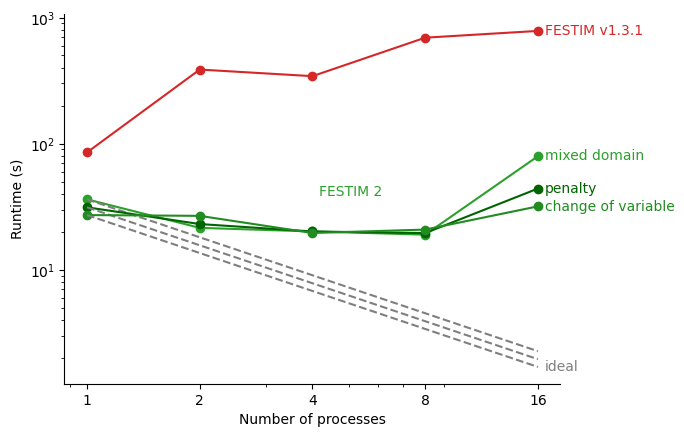

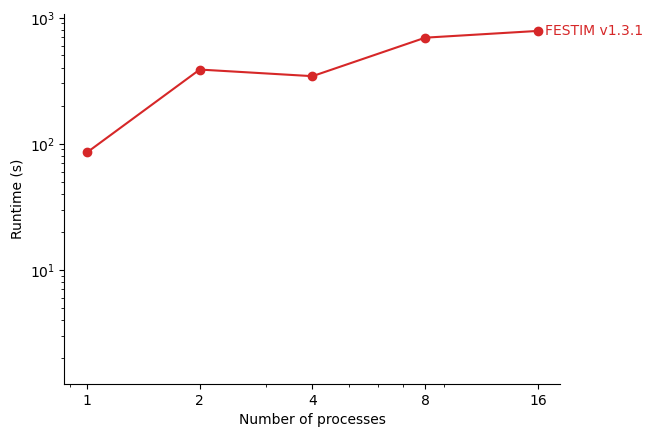

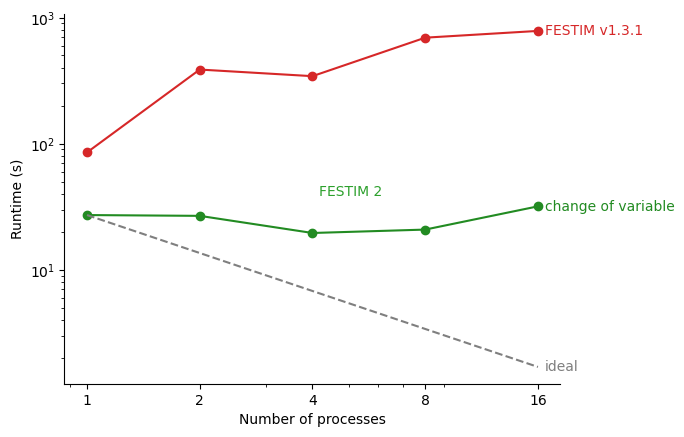

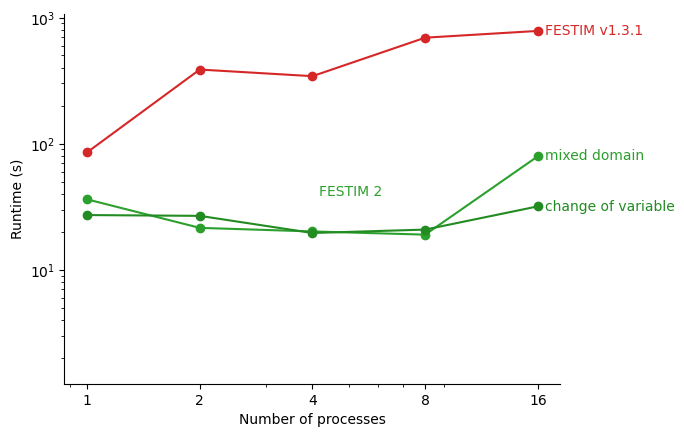

In [12]:
import matplotlib.pyplot as plt
from festim import __version__


def plot_runtime(
    runtimes_mixed: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    penalty: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
):
    lines = []
    if runtimes_mixed is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_mixed, marker="o", label=f"mixed domain", color="tab:green"
        )
        lines.append(l_mixed)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_mixed[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if penalty is not None:
        # another green
        (l_penalty,) = plt.plot(
            num_procs, runtimes_penalty, marker="o", label="penalty", color="darkgreen"
        )
        lines.append(l_penalty)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_penalty[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n,
                runtimes_change_of_var[0] * n**-1,
                label="ideal",
                linestyle="--",
                color="tab:grey",
            )
            lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            (l_festim1,) = plt.plot(
                data["num_procs"],
                data["runtimes"],
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (num_procs[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_mixed  is not None or runtimes_change_of_var is not None or penalty is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes_change_of_var[2]),
            textcoords="offset points",
            xytext=(5, 30),
            ha="left",
            va="center",
            color="tab:green",
        )

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Runtime (s)")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs, num_procs)

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

# show everything
plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, penalty=True, show_ideal=True)
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.show()

# only festim1
plot_runtime()
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

# festim1 + change of var
plot_runtime(runtimes_change_of_var=runtimes_change_of_var)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

# festim1 + change of var + mixed
plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, show_ideal=False)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()


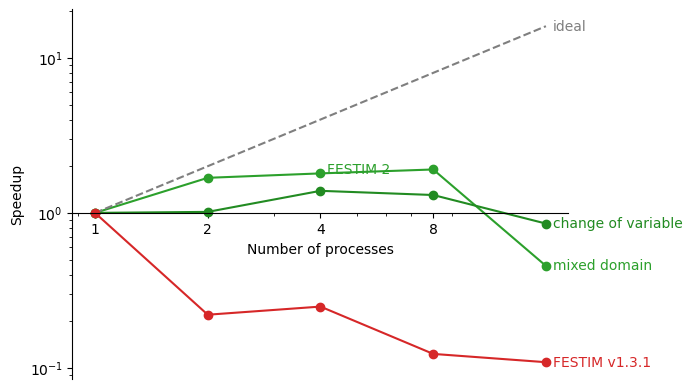

In [13]:
def plot_speedup(
    runtimes_mixed: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
):
    lines = []
    if runtimes_mixed is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_mixed[0] / runtimes_mixed, marker="o", label=f"mixed domain", color="tab:green"
        )
        lines.append(l_mixed)

    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var[0] / runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)

    if show_ideal:
        n = np.linspace(1, 16, 100)
        (l_ideal,) = plt.plot(
            n,
            n,
            label="ideal",
            linestyle="--",
            color="tab:grey",
        )
        lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            (l_festim1,) = plt.plot(
                data["num_procs"],
                data["runtimes"][0] / data["runtimes"],
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (num_procs[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_mixed is not None or runtimes_change_of_var is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes[2]/runtimes[0]),
            textcoords="offset points",
            xytext=(5, 60),
            ha="left",
            va="center",
            color="tab:green",
        )

    # move xaxis to y=1
    plt.gca().spines['bottom'].set_position(('data', 1))

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Speedup")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs[:-1], num_procs[:-1])

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

plot_speedup(runtimes_mixed=runtimes, runtimes_change_of_var=runtimes_change_of_var, show_ideal=True)